In [2]:
import anndata
import umap
import xgboost
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import pickle
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from IPython.display import display, Image, HTML
import mlflow
import re
regex = re.compile(r"perturbation_experiment_([^_]+)_level")



levels = ["0", "0.5", "1.0"]
data_dir = "/data/gene_perturbation_colon_epithelial_scGPT_with_binning_1"
file_pattern = data_dir + "/perturbation_experiment_{gene}_level_{level}"
base_fname = file_pattern.format(gene = "JUND", level = "1.0")
base_embeddings = np.load(f"{base_fname}.embeddings.npy")
adata = anndata.read_h5ad(f"{base_fname}.h5ad")
base_df = adata.obs[["tissue", "cell_type", 'sex', 'development_stage',"disease"]].copy()
with open(f"crohn_classifier2.xgboost.pkl", "rb") as f:
    xgb_model = pickle.load(f)
genes = set([regex.search(f.name).group(1) for f in list(Path(data_dir).glob("*.npy"))])
base_df.sample(5)

,tissue,cell_type,sex,development_stage,disease
cell_id,,,,,
N130084_E-TATCAGGGTTAGAGAT,colonic epithelium,epithelial cell,female,fifth decade human stage,Crohn disease
N130084_E-ATAGACCGTGCGACAA,colonic epithelium,enterocyte,female,fifth decade human stage,Crohn disease
N178961_L-GGAAGTGTCAGGACAG,lamina propria of mucosa of colon,goblet cell,male,seventh decade human stage,Crohn disease
N114902_N-ACACCCTTCTTTAGTC,colon,enterocyte,male,fourth decade human stage,Crohn disease
N114902_N-ACTTTCATCTGTACGA,colon,stem cell,male,fourth decade human stage,Crohn disease


In [2]:

umap_name = "base_umap_crohn_data_control_embeddings_2024-03-05.pkl"
if Path(umap_name).exists():
     with open(umap_name, "rb") as f:
        base_umap = pickle.load(f)
else:
    base_umap = umap.UMAP().fit(base_embeddings)
    with open(umap_name, "wb") as f:
        pickle.dump(base_umap, f)
base_df[["umap_x", "umap_y"]] = base_umap.transform(base_embeddings)

In [3]:
base_df.head()

,tissue,cell_type,sex,development_stage,disease,umap_x,umap_y
cell_id,,,,,,,
N105446_L-ATTGTTCCAAACGTGG,lamina propria of mucosa of colon,paneth cell,male,third decade human stage,Crohn disease,3.702878,1.497307
N105446_L-TCGACGGGTGAGACCA,lamina propria of mucosa of colon,paneth cell,male,third decade human stage,Crohn disease,3.852242,1.299315
N105446_L-AGTAACCGTTAAGGGC,lamina propria of mucosa of colon,paneth cell,male,third decade human stage,Crohn disease,3.844906,1.272961
N105446_L-GCAGGCTTCGCTAAAC,lamina propria of mucosa of colon,goblet cell,male,third decade human stage,Crohn disease,6.133603,1.840456
N105446_L-ATCTTCATCTGAGAGG,lamina propria of mucosa of colon,goblet cell,male,third decade human stage,Crohn disease,6.173119,1.949079


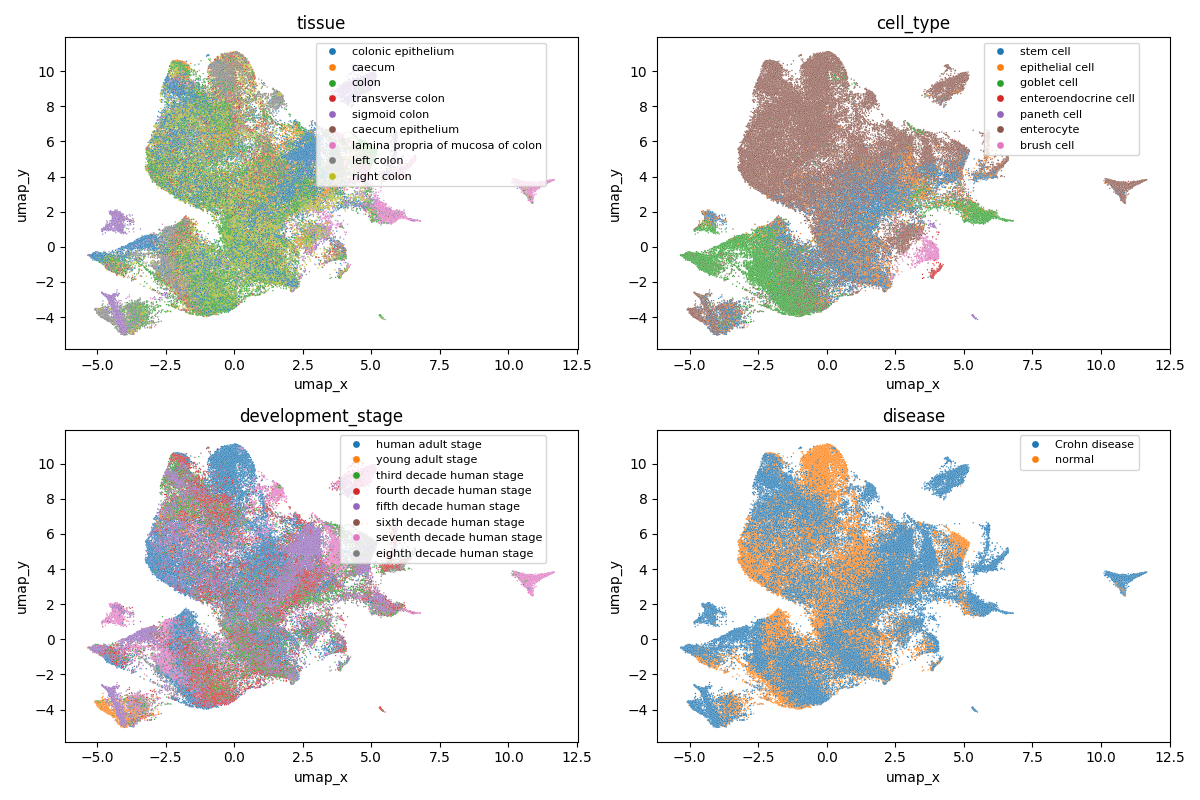

In [4]:
imagefile  = "base_umap_crohn_data_control_embeddings_2024-03-05.png"
if not Path(imagefile).exists():
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    cols = ["tissue", "cell_type", "development_stage", "disease"]
    indexes = [[0,0], [0,1], [1,0], [1,1]]
    for idx, col in enumerate(cols):
        axes = axs[indexes[idx][0], indexes[idx][1]]
        sns.scatterplot(data=base_df, x="umap_x", y="umap_y", hue=col, ax=axes, s=1)
        axes.set_title(col)
        axes.legend(bbox_to_anchor=(0.95, 1), ncol=1, fontsize=8, markerscale=5, loc='upper right')

    plt.tight_layout();
    plt.savefig(imagefile)

display(Image(imagefile))

In [5]:
# machine learning models for the perturbations
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)

# import randomforest classier, logistic regression, and xgboost:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

# Set up the experiment and enable autologging
mlflow.set_experiment("perturbation_experiment_predict_disease")
mlflow.sklearn.autolog()

results_filename = "results_df-2024-05-05.csv"
def evaluate_model(model, x, y):
    results = []

    for train_idx, test_idx in StratifiedKFold(n_splits=3, shuffle=True).split(x, y):
        x_train, x_test = x[train_idx], x[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        scores = {
            "model": model.__class__.__name__,
            "accuracy": accuracy_score(y_test, y_pred),
            "f1": f1_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
        }
        results.append(scores)
        # log everything but not the "model" name:
        mlflow.log_metrics({k: v for k, v in scores.items() if k != "model"})

    return results

if not Path(results_filename).exists():
    x = base_embeddings
    y = pd.Categorical(adata.obs["disease"]).codes

    models = [
        LogisticRegression(max_iter=2000, random_state=42, n_jobs=-1),
        xgboost.XGBClassifier(n_jobs=-1),
        RandomForestClassifier(random_state=0, n_jobs=-1),
    ]

    results = []
    for model in tqdm(models, desc="Training models"):
        with mlflow.start_run(run_name=model.__class__.__name__):
            results.extend(evaluate_model(model, x, y))

    results_df = pd.DataFrame(results)
    results_df.to_csv(results_filename, index=False)

results_df = pd.read_csv(results_filename)

# Format the grouped mean results with 2 decimal precision
results_df.groupby("model").mean().style.format("{:.2f}")

    


,accuracy,f1,precision,recall
model,,,,
LogisticRegression,0.88,0.87,0.88,0.86
RandomForestClassifier,0.85,0.84,0.84,0.83
XGBClassifier,0.88,0.87,0.87,0.87


In [6]:
model_filename = "cgboost_on_emebeddings_with_binning_predict_disease_2024-05-05.pkl"
if not Path(model_filename).exists():
    model = xgboost.XGBClassifier(n_jobs=-1).fit(x, y)
    with open(model_filename, "wb") as f:
        pickle.dump(model, f)
else:
    with open(model_filename, "rb") as f:
        model = pickle.load(f)
        


In [7]:
# now iterqte on all genes and calculte the pertubation effect by loading the embeddings and passing it trough the 'model'ArithmeticError
base_df["disease_proba"] = model.predict_proba(base_embeddings)[:, 0]
naming = {0: "KO", 5.0 : "OE"}
dfs = []
genes_bar = tqdm(genes, desc="Calculating perturbation effect")
for gene in genes_bar:
    for level in [0, 5.0]:
        df = base_df.copy().assign(gene = gene, level=naming[level])
        filename = file_pattern.format(gene = gene, level = level) + ".embeddings.npy"
        emb = np.load(filename)
        df["proba_perturbed"] = model.predict_proba(emb)[:,0]
        dfs.append(df)
perturbation_df = pd.concat(dfs)
perturbation_df.sample(10, random_state=42)
perturbation_df["proba_disease_after_pertrubation"] = perturbation_df["proba_perturbed"] - perturbation_df["disease_proba"]


Calculating perturbation effect: 100%|██████████| 7/7 [00:14<00:00,  2.02s/it]


In [8]:
# how many cells for each perturbations has changed the probability of the disease:
perturbation_df["disease_change"] = perturbation_df["proba_disease_after_pertrubation"].abs() > 0.01
perturbation_df.groupby(["gene", "level", "disease_change"])["disease_change"].count()

gene    level  disease_change
CD320   KO     False             32816
               True              64972
        OE     False             32056
               True              65732
CTNNB1  KO     False             32713
               True              65075
        OE     False             31436
               True              66352
IFI6    KO     False             32693
               True              65095
        OE     False             32603
               True              65185
IL23R   KO     False             32740
               True              65048
        OE     False             32686
               True              65102
JUND    KO     False             32670
               True              65118
        OE     False             30581
               True              67207
NOD2    KO     False             32604
               True              65184
        OE     False             32676
               True              65112
RAC1    KO     False             3

In [3]:
# sanity - check - does the genes that we picked has any relevant differential expressiokn between the disease and the control?
if not "ad" in globals():
    ad = anndata.read_h5ad(
        "/data/colon_epithelial_cellxgene/ae802158-1a7e-43e0-9c23-cdc688ce3481.h5ad"
    )
    # get the numeric index of the genes:
    numric_indexes = ad.var.reset_index()
    idx = numric_indexes[numric_indexes["feature_name"].isin(genes)].index.tolist()
    expression = pd.DataFrame(ad.X[:, idx].todense(), columns=list(genes))
    expression["disease"] = ad.obs["disease"].values
(expression.groupby("disease").mean().T.rename(columns = {"Crohn disease": "disease"})
.eval("diff_ = disease - normal")
)


/tmp/ipykernel_22199/1842938070.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  (expression.groupby("disease").mean().T.rename(columns = {"Crohn disease": "disease"})


disease,disease,normal,diff_
NOD2,0.239943,0.084657,0.155286
IL23R,0.009299,0.005134,0.004166
JUND,1.143484,0.658037,0.485448
CTNNB1,2.799416,2.789391,0.010025
CD320,0.001779,0.000344,0.001435
IFI6,0.647560,0.761272,-0.113712
RAC1,2.005170,1.325948,0.679222


In [4]:
# this is very low...
# we might need different genes to perturbate !
# let's try to find the genes that are most relevant to the disease:
res = (
    adata.to_df()
    .assign(disease=adata.obs["disease"])
    # .assign(cell_type=adata.obs["cell_type"])
    .groupby(["disease"])
    .median()
    .T.rename(columns={"Crohn disease": "disease"})
    .eval("diff_ = abs(disease - normal)")
    .eval("mid_ = (disease + normal)/2")
    .query("mid_ > 0.3") # have some expression in general
    .sort_values("diff_", ascending=False)
)

top_diff_genes = res.index[0:5]
bot_diff_genes = res.index[-5:]

res

/tmp/ipykernel_22199/1431029411.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["disease"])


disease,disease,normal,diff_,mid_
CEACAM5,1.448253,0.000000,1.448253,0.724126
JUND,1.187466,0.000000,1.187466,0.593733
ZG16,0.825744,0.000000,0.825744,0.412872
MT1G,1.366468,2.086770,0.720302,1.726619
CA2,1.289716,1.888090,0.598374,1.588903
SELENBP1,1.087844,1.654481,0.566637,1.371163
MT-ND3,2.636963,2.152762,0.484200,2.394863
FXYD3,2.109229,2.503806,0.394577,2.306517
MALAT1,2.827384,2.510149,0.317235,2.668767
RPL39,2.287398,1.988382,0.299016,2.137890


In [5]:
top_diff_genes, bot_diff_genes

(Index(['CEACAM5', 'JUND', 'ZG16', 'MT1G', 'CA2'], dtype='object'),
 Index(['IFI27', 'TSPAN1', 'KRT19', 'MT-ND2', 'MT-ATP6'], dtype='object'))

| Gene      | Related to Crohn's Disease? | Reason                                                                                         |
|-----------|----------------------------|------------------------------------------------------------------------------------------------|
| **CEACAM5** | Yes                        | Reduced expression of CEACAM5 in intestinal epithelial cells (IECs) is linked to reduced activation of CD8+ T-regulatory cells, contributing to inflammation in CD patients. CEACAM5 peptides may restore Treg activity and reduce inflammation&#8203;``【oaicite:2】``&#8203;. CEACAM5 expression is significantly increased in colonic biopsies of pediatric CD patients compared to controls&#8203;``【oaicite:1】``&#8203;. |
| **JUND**   | No confirmed direct link    | There is limited information directly linking JUND to Crohn's disease. Further research is needed. |
| **ZG16**   | Potentially                | Although primarily associated with antimicrobial defense and mucosal health, changes in ZG16 expression have been noted in inflammatory bowel disease (IBD). However, more research is needed to establish a direct link with Crohn's disease specifically. |
| **MT1G**   | No confirmed direct link    | Metallothionein genes like MT1G are involved in metal ion homeostasis and antioxidant defenses, but there is no strong evidence linking MT1G directly to Crohn's disease. |
| **CA2**    | Potentially                | CA2 expression is altered in inflammatory conditions. In CD, reduced expression of CA2 has been observed, but further research is required to confirm its involvement in Crohn's disease&#8203;``【oaicite:0】``&#8203;. |
| **IFI27** | Yes                        | IFI27 (Interferon Alpha Inducible Protein 27) negatively modulates interferon (IFN) responses, potentially playing a role in Crohn's disease through its impact on the immune response. Reduced expression of IFI27 increases the expression of other immune-related genes like IFIT2 and IFNL1, which might influence inflammation&#8203;``【oaicite:5】``&#8203;&#8203;``【oaicite:4】``&#8203;. |
| **TSPAN1**| Potentially                | TSPAN1 (Tetraspanin 1) may have a role in immune signaling due to its involvement in cellular processes such as cell adhesion, proliferation, and migration. However, the direct link to Crohn's disease is not yet well-established and needs further research&#8203;``【oaicite:3】``&#8203;. |
| **KRT19** | Yes                        | KRT19 (Keratin 19) has been found among the 126 genes significantly associated with Crohn's disease. Its functional analysis indicated an impact on the disease susceptibility, especially in the intestinal epithelial compartment&#8203;``【oaicite:2】``&#8203;. |
| **MT-ND2**| Potentially                | MT-ND2 (Mitochondrially Encoded NADH: Ubiquinone Oxidoreductase Core Subunit 2) is linked to mitochondrial function. While mitochondrial dysfunction has been implicated in IBDs, including Crohn's disease, a direct link to MT-ND2 is not confirmed&#8203;``【oaicite:1】``&#8203;. |
| **MT-ATP6**| Potentially               | MT-ATP6 (Mitochondrially Encoded ATP Synthase Membrane Subunit 6) is crucial for mitochondrial ATP production. Similar to MT-ND2, mitochondrial dysfunction may contribute to Crohn's disease pathology, but specific evidence linking MT-ATP6 to Crohn's disease is limited&#8203;``【oaicite:0】``&#8203;. |



## Potential control genes:
| Gene      | Function                                  | Colon Expression | Crohn's Disease Association? | Reference                                           |
|-----------|------------------------------------------|-----------------|-----------------------------|----------------------------------------------------|
| **GAPDH** | Glycolysis (Energy metabolism)           | Yes             | No                          | [Ref. 21](#21)                                    |
| **ACTB**  | Cytoskeletal protein (Structural integrity)| Yes          | No                          | [Ref. 22](#22)                                    |
| **TUBB**  | Cytoskeletal protein (Microtubules)      | Yes             | No                          | [Ref. 23](#23)                                    |
| **RPLP0** | Ribosomal protein (Protein synthesis)    | Yes             | No                          | [Ref. 24](#24)                                    |
| **HPRT1** | Purine metabolism (Housekeeping gene)    | Yes             | No                          | [Ref. 25](#25)                                    |


In [6]:
potential_control_genes = [
    "GAPDH",
    "ACTB",
    "TUBB",
    "RPLP0",
    "HPRT1",
    "PGK1",
    "YWHAZ",
    "B2M",
    "EEF1A1",
    "PPIA"
]

In [35]:
if not "ad_df" in globals():
    ad_df = adata.to_df().assign(disease=adata.obs["disease"])

# does potential_control_genes in the data?
print(
    "control genes in the adata 1800 genes?:",
    len([gene for gene in potential_control_genes if gene in ad_df.columns]),
)

numric_indexes = ad.var.reset_index()
idx = numric_indexes[
    numric_indexes["feature_name"].isin(potential_control_genes)
].index.tolist()
expression = pd.DataFrame(ad.X[:, idx].todense(), columns=list(potential_control_genes))
expression["disease"] = ad.obs["disease"].values

expression.groupby("disease").mean().T.rename(
    columns={"Crohn disease": "disease"}
).eval("diff_ = abs(disease - normal)").sort_values("diff_", ascending=False)


control genes in the adata 1800 genes?: 0


/tmp/ipykernel_22199/1847664113.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  expression.groupby("disease").mean().T.rename(


disease,disease,normal,diff_
YWHAZ,2.358491,1.324108,1.034383
EEF1A1,4.085546,4.666076,0.580530
PPIA,5.732670,5.279491,0.453179
ACTB,5.118537,5.514886,0.396349
B2M,4.678497,5.037348,0.358851
RPLP0,3.054183,3.262532,0.208350
TUBB,4.717336,4.854537,0.137201
HPRT1,1.430339,1.466120,0.035781
PGK1,0.425993,0.407494,0.018499
GAPDH,1.272465,1.254772,0.017693


In [42]:
control_genes_non_colon_specific = [
    "TBP",
    "UBC",
    "RPL13A",
    "GUSB",
    "HSP90AB1"
]

In [43]:
idx = numric_indexes[
    numric_indexes["feature_name"].isin(control_genes_non_colon_specific)
].index.tolist()
expression = pd.DataFrame(ad.X[:, idx].todense(), columns=list(control_genes_non_colon_specific))
expression["disease"] = ad.obs["disease"].values

expression.groupby("disease").mean().T.rename(
    columns={"Crohn disease": "disease"}
).eval("diff_ = abs(disease - normal)").sort_values("diff_", ascending=False)

/tmp/ipykernel_22199/2249463631.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  expression.groupby("disease").mean().T.rename(


disease,disease,normal,diff_
HSP90AB1,5.057222,5.897473,0.840251
TBP,2.487752,2.172127,0.315625
GUSB,3.332968,3.188726,0.144242
RPL13A,0.478832,0.533561,0.054729
UBC,0.090920,0.082896,0.008023


In [46]:
# OK, so the genes we should check:
crohn_genes = ['CEACAM5', 'JUND', 'ZG16', 'MT1G', 'CA2']
crohn_genes_but_not_differentially_epressed = ["KRT19", "TSPAN1"]
control_genes = ['GAPDH', 'PGK1', 'HPRT1']
control_genes_non_colon_specific = [
    "TBP",
    "GUSB",
    "HSP90AB1"
]

all_together = crohn_genes + control_genes + crohn_genes_but_not_differentially_epressed + control_genes_non_colon_specific

" ".join(all_together)

'CEACAM5 JUND ZG16 MT1G CA2 GAPDH PGK1 HPRT1 KRT19 TSPAN1 TBP GUSB HSP90AB1'

In [48]:
# make this a dataset name:
f"colon_epithelial_cellxgene_perturbation{'_'.join(all_together)}_genes"

'colon_epithelial_cellxgene_perturbationCEACAM5_JUND_ZG16_MT1G_CA2_GAPDH_PGK1_HPRT1_KRT19_TSPAN1_TBP_GUSB_HSP90AB1_genes'